In [ ]:
# MIT License
#
# Copyright (c) 2020 Fagner Cunha
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Redes Neurais Convolutivas com TensorFlow

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/alcunha/nn-with-tf/blob/master/Convolutional-Neural-Networks-with-TF.ipynb"><img src="./images/colab_logo_32px.png" />Executar no Google Colab</a>
  </td>
  <td>
    <a href="https://github.com/alcunha/nn-with-tf/blob/master/Convolutional-Neural-Networks-with-TF.ipynb"><img src="./images/GitHub-Mark-32px.png" />Ver código no GitHub</a>
  </td>
</table>

*“NÃO ENTRE EM PÂNICO”*

(O Guia do Mochileiro das Galáxias)

In [ ]:
! pip install tensorflow tensorflow_datasets tfds-nightly matplotlib

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras

AUTOTUNE = tf.data.experimental.AUTOTUNE

Colocar mnist original e explicar o fashion mnist

In [29]:
def tuple2dict(image, label):
    sample_dict = {
        'image': image,
        'label': label
    }
    return sample_dict

def show_examples(dataset, info):
    dataset = dataset.map(tuple2dict, num_parallel_calls=AUTOTUNE)
    tfds.show_examples(dataset, info, rows=2, cols=4)
    plt.close()

In [82]:
(fmnist_train, fmnist_test), info = tfds.load('fashion_mnist',
                                              split=['train', 'test'],
                                              shuffle_files=True,
                                              as_supervised=True,
                                              with_info=True)

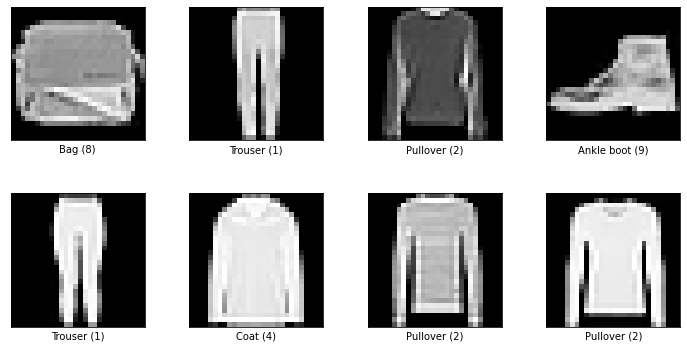

In [83]:
show_examples(fmnist_train, info)

In [84]:
print(info)

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [85]:
print(info.features['image'])

Image(shape=(28, 28, 1), dtype=tf.uint8)


In [86]:
print(info.features["label"].names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [87]:
info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [88]:
print(info.features["label"].num_classes)

10


In [89]:
print(info.features["label"].names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [90]:
image, label = next(iter(fmnist_train))

In [91]:
image

<tf.Tensor: shape=(28, 28, 1), dtype=uint8, numpy=
array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],


In [92]:
label

<tf.Tensor: shape=(), dtype=int64, numpy=2>

In [93]:
label.numpy()

2

In [94]:
info.features['label'].int2str(label.numpy())

'Pullover'

In [95]:
TRAIN_LENGHT = info.splits['train'].num_examples
TEST_LENGHT = info.splits['test'].num_examples
NUM_CLASSES = info.features['label'].num_classes

In [108]:
EPOCHS = 10
BATCH_SIZE = 128

In [97]:
def apply_agumentation(image, label):
    image = tf.image.random_flip_left_right(image)
    
    return image, label

In [98]:
fmnist_train = fmnist_train.map(apply_agumentation, num_parallel_calls=AUTOTUNE)
fmnist_train = fmnist_train.shuffle(buffer_size=TRAIN_LENGHT)
fmnist_train = fmnist_train.batch(BATCH_SIZE, drop_remainder=True)
fmnist_train = fmnist_train.prefetch(buffer_size=AUTOTUNE)

In [99]:
images, labels = next(iter(fmnist_train))

In [100]:
images.shape

TensorShape([128, 28, 28, 1])

In [101]:
labels.shape

TensorShape([128])

In [102]:
labels

<tf.Tensor: shape=(128,), dtype=int64, numpy=
array([4, 7, 6, 9, 4, 1, 5, 8, 6, 2, 1, 6, 6, 4, 0, 0, 4, 0, 8, 3, 3, 0,
       8, 9, 7, 5, 7, 4, 7, 0, 1, 8, 5, 9, 6, 1, 2, 6, 4, 9, 5, 8, 3, 6,
       4, 9, 9, 9, 9, 8, 6, 2, 3, 1, 1, 9, 4, 6, 9, 0, 0, 3, 7, 4, 0, 0,
       5, 2, 9, 3, 9, 9, 5, 5, 7, 2, 3, 0, 4, 2, 6, 9, 4, 6, 6, 6, 1, 1,
       6, 3, 4, 4, 5, 0, 2, 9, 3, 1, 1, 6, 5, 4, 7, 0, 8, 8, 6, 3, 8, 2,
       3, 2, 8, 1, 6, 4, 7, 7, 7, 8, 0, 0, 2, 4, 6, 8, 8, 3])>

In [103]:
fmnist_test = fmnist_test.batch(BATCH_SIZE, drop_remainder=True)
fmnist_test = fmnist_test.prefetch(buffer_size=AUTOTUNE)

In [109]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2, 2)))
model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(10))

In [110]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 128)        

In [111]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

In [112]:
history = model.fit(fmnist_train,
                      epochs=EPOCHS,
                      validation_data=fmnist_test,
                      validation_steps=TEST_LENGHT // BATCH_SIZE)

Epoch 1/10
468/468 [==============================] - 3s 7ms/step - loss: 0.4776 - accuracy: 0.8352 - val_loss: 0.5695 - val_accuracy: 0.7799
Epoch 2/10
468/468 [==============================] - 3s 7ms/step - loss: 0.2818 - accuracy: 0.8982 - val_loss: 0.3499 - val_accuracy: 0.8724
Epoch 3/10
468/468 [==============================] - 3s 7ms/step - loss: 0.2434 - accuracy: 0.9117 - val_loss: 0.3337 - val_accuracy: 0.8808
Epoch 4/10
468/468 [==============================] - 3s 7ms/step - loss: 0.2207 - accuracy: 0.9199 - val_loss: 0.2646 - val_accuracy: 0.9037
Epoch 5/10
468/468 [==============================] - 3s 7ms/step - loss: 0.2021 - accuracy: 0.9269 - val_loss: 0.2705 - val_accuracy: 0.9040
Epoch 6/10
468/468 [==============================] - 3s 7ms/step - loss: 0.1897 - accuracy: 0.9317 - val_loss: 0.2861 - val_accuracy: 0.8969
Epoch 7/10
468/468 [==============================] - 3s 7ms/step - loss: 0.1790 - accuracy: 0.9352 - val_loss: 0.2520 - val_accuracy: 0.9088
Epoch 

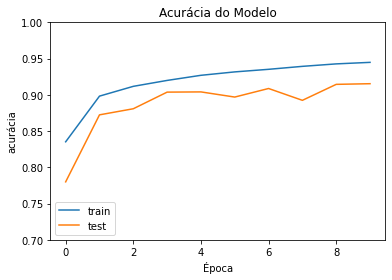

In [116]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.7, 1])
plt.title('Acurácia do Modelo')
plt.ylabel('acurácia')
plt.xlabel('Época')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

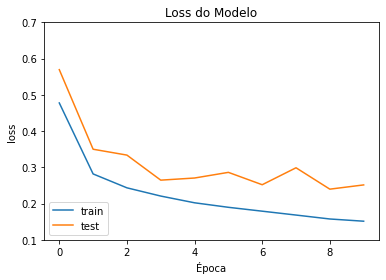

In [118]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.1, 0.7])
plt.title('Loss do Modelo')
plt.ylabel('loss')
plt.xlabel('Época')
plt.legend(['train', 'test'], loc='lower left')
plt.show()